# Where to Open a Coffee Shop in Los Angeles (LA)

## Introduction

_Opening a coffee shop, or any restaurant for that matter, can be extremely difficult - especially during the current pandemic. One of the most difficult and critical choices of any business owner is locating their shop. In the restaurant business a good location is often a significant factor in the ability of the restaurant to make it and suceed. The goal of this project and analysis is to determine what locations within the LA county a potentially offer a business owner the ideal location for a coffee shop targeting working adults_

This "ideal" location will be defined by a few critical factors: 
* Proximity to other coffee shops or cafes
* Proximity to offices to target working adults

## Data Sources

In order to complete this analysis some critical data needs to be located:
* Location of coffee shops and cafes in LA
* Location of offices in LA

To get this data the follow sources will need to be used:

* Foursquare API to help provide the locations of various coffee shops
* Foursquare API to help provide the locations of various offices 
* List of neighborhoods in LA which has been made available by UCLA

This data will allow us to compare the various parts of LA to determine which neighborhood will be an ideal cadidate for a coffee shop targeting working adults

## Data Gathering

In this section we will gather the data necessary for analysis. I will first load the LA neighborhood data and then gather the necessary info from the Foursquare API

In [1]:
!pip install geojson
!pip install folium
!pip install geopandas
!pip install turfpy
!pip install shapely
!pip install pyshp

     |████████████████████████████████| 94 kB 3.8 MB/s  eta 0:00:01
     |████████████████████████████████| 962 kB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 23.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 49.9 MB/s eta 0:00:01
     |████████████████████████████████| 6.4 MB 28.1 MB/s eta 0:00:01
  Created wheel for turfpy: filename=turfpy-0.0.5-py3-none-any.whl size=35770 sha256=0311efe63348ee038f99b49fb750a75ab9533c17b1df699cacf347634ee73ec2
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/53/51/07/b7d8a2dafe7e49dd5f7de2351d00f06616f6c4412619119498
Successfully built turfpy


In [2]:
#gather the info for the Atlanta neighborhoods 
import geopandas as gpd
import turfpy
import pandas as pd
import numpy as np
from turfpy.measurement import centroid
import requests
from shapely.geometry import shape
from geojson import Polygon


la_data = 'http://gis.ucla.edu/geodata/dataset/93d71e41-6196-4ecb-9ddd-15f1a4a7630c/resource/6cde4e9e-307c-477d-9089-cae9484c8bc1/download/la-county-neighborhoods-v6.geojson'
la_df = gpd.read_file(la_data)

#get the center of the various LA neighborhoods to assist in searching for coffee shops
la_df['Latitude'] = la_df['geometry'].centroid.y
la_df['Longitude'] = la_df['geometry'].centroid.x

la_df.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



kind      external_id             name  \
0  L.A. County Neighborhood (V6)            acton            Acton   
1  L.A. County Neighborhood (V6)  adams-normandie  Adams-Normandie   
2  L.A. County Neighborhood (V6)     agoura-hills     Agoura Hills   
3  L.A. County Neighborhood (V6)       agua-dulce       Agua Dulce   
4  L.A. County Neighborhood (V6)         alhambra         Alhambra   

                                        slug  \
0            acton-la-county-neighborhood-v6   
1  adams-normandie-la-county-neighborhood-v6   
2     agoura-hills-la-county-neighborhood-v6   
3       agua-dulce-la-county-neighborhood-v6   
4         alhambra-la-county-neighborhood-v6   

                                             set  \
0  /1.0/boundary-set/la-county-neighborhoods-v6/   
1  /1.0/boundary-set/la-county-neighborhoods-v6/   
2  /1.0/boundary-set/la-county-neighborhoods-v6/   
3  /1.0/boundary-set/la-county-neighborhoods-v6/   
4  /1.0/boundary-set/la-county-neighborhoods-v6/   

                                            metadata  \
0  {'city': '', 'name': 'Acton', 'region': 'antel...   
1  {'city': 'los-angeles', 'name': 'Adams-Normand...   
2  {'city': '', 'name': 'Agoura Hills', 'region':...   
3  {'city': '', 'name': 'Agua Dulce', 'region': '...   
4  {'city': '', 'name': 'Alhambra', 'region': 'sa...   

                                        resource_uri  \
0     /1.0/boundary/acton-la-county-neighborhood-v6/   
1  /1.0/boundary/adams-normandie-la-county-neighb...   
2  /1.0/boundary/agoura-hills-la-county-neighborh...   
3  /1.0/boundary/agua-dulce-la-county-neighborhoo...   
4  /1.0/boundary/alhambra-la-county-neighborhood-v6/   

                                            geometry   Latitude   Longitude  
0  MULTIPOLYGON (((-118.20703 34.53902, -118.1894...  34.495582 -118.185759  
1  MULTIPOLYGON (((-118.30800 34.03740, -118.3006...  34.031363 -118.300314  
2  MULTIPOLYGON (((-118.77621 34.16816, -118.7263...  34.151085 -118.760563  
3  MULTIPOLYGON (((-118.37822 34.48811, -118.3783...  34.510666 -118.312386  
4  MULTIPOLYGON (((-118.12175 34.10504, -118.1168...  34.083994 -118.135471

In [3]:
#get foursquare info regarding various restaruants in the LA area
CLIENT_ID = 'ESW2O5H4KM2FXQJPDNTOESDLCIDK5ETP2JFT4EIHJAWZ1JDG'
CLIENT_SECRET = 'DLT5QD1AC5QCSH5IJZ4D1U42XV3HYKPL1CN5KLKXCSRSLGND' 
VERSION = '20210124'

import json

def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT = 50):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items'] 
            venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']      
        except:
            venues_list = []
    return(nearby_venues)

la_places = getNearbyVenues(names=la_df['name'],
                                   latitudes=la_df['Latitude'],
                                   longitudes=la_df['Longitude']
                                  )
print(la_places)

         Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0               Acton              34.495582             -118.185759   
1               Acton              34.495582             -118.185759   
2               Acton              34.495582             -118.185759   
3     Adams-Normandie              34.031363             -118.300314   
4     Adams-Normandie              34.031363             -118.300314   
...               ...                    ...                     ...   
8609      Yorba Linda              33.895626             -117.771632   
8610      Yorba Linda              33.895626             -117.771632   
8611      Yorba Linda              33.895626             -117.771632   
8612      Yorba Linda              33.895626             -117.771632   
8613      Yorba Linda              33.895626             -117.771632   

                                 Venue  Venue Latitude  Venue Longitude  \
0                               SUBWAY       34.493552      

In [4]:
#view various categories for venues for reference
la_places['Venue Category'].unique()

array(['Sandwich Place', 'Diner', 'Sushi Restaurant', 'Taco Place',
       'Mexican Restaurant', 'Pizza Place', 'Indie Theater', 'Café',
       'Hardware Store', 'Restaurant', 'South American Restaurant',
       'Coffee Shop', 'Supermarket', 'Himalayan Restaurant',
       'Indian Restaurant', 'Burger Joint', 'ATM', 'Cosmetics Shop',
       'Ice Cream Shop', 'Video Store', 'Grocery Store', 'Scenic Lookout',
       'Fast Food Restaurant', 'Donut Shop', 'Farmers Market',
       'Home Service', 'Donburi Restaurant', 'Thai Restaurant',
       'Deli / Bodega', 'Gym', 'Middle Eastern Restaurant',
       'Breakfast Spot', 'Dessert Shop', 'BBQ Joint', 'Bakery',
       'Pharmacy', 'Brewery', 'Italian Restaurant', 'American Restaurant',
       'Steakhouse', 'Sports Bar', 'Shipping Store', 'Multiplex',
       'Japanese Restaurant', 'Bank', 'Gas Station', 'Lounge', 'Hotel',
       'Chinese Restaurant', 'Park', 'Airport', 'Szechuan Restaurant',
       'Asian Restaurant', 'Vietnamese Restaurant', 'Du

In [5]:
#get the list of coffee shops in the LA area using coffee and cafe as the search terms
la_places['Venue Category'] = la_places['Venue Category'].astype('string')
search_coffee = ['Coffee','Café']
la_coffee = la_places[la_places['Venue Category'].str.contains('|'.join(search_coffee))]
la_coffee

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
9     Adams-Normandie              34.031363             -118.300314   
13    Adams-Normandie              34.031363             -118.300314   
15    Adams-Normandie              34.031363             -118.300314   
52       Agoura Hills              34.151085             -118.760563   
89       Agoura Hills              34.151085             -118.760563   
...               ...                    ...                     ...   
8509   Windsor Square              34.069092             -118.319896   
8534   Woodland Hills              34.166333             -118.604942   
8552   Woodland Hills              34.166333             -118.604942   
8564   Woodland Hills              34.166333             -118.604942   
8580      Yorba Linda              33.895626             -117.771632   

                       Venue  Venue Latitude  Venue Longitude Venue Category  
9              Ignatius Cafe       34.031772      -118.293006           Café  
13          Blu Elefant Café       34.039827      -118.303951           Café  
15                 Starbucks       34.025776      -118.308577    Coffee Shop  
52               Urbane Cafe       34.146573      -118.758956           Café  
89                 Starbucks       34.153631      -118.759182    Coffee Shop  
...                      ...             ...              ...            ...  
8509          Cafe Americano       34.062067      -118.314581    Coffee Shop  
8534               Starbucks       34.169307      -118.605482    Coffee Shop  
8552  Coffee Bean & Tea Leaf       34.168214      -118.603009    Coffee Shop  
8564              Leo & Lily       34.168219      -118.615152           Café  
8580               Starbucks       33.891252      -117.775566    Coffee Shop  

[432 rows x 7 columns]

In [6]:
#get the list of potential offices or work locations in the LA area - Bank, Business Service, Financial or Legal Service, Construction & Landscaping, 
#Doctor's Office, Lawyer, IT Services, Insurance Office, Design Studio, Medical Center, Office, College Administrative Building
search_office = ['Bank', 'Business Service', 'Financial or Legal Service', 'Construction & Landscaping', "Doctor's Office", 'Lawyer', 'IT Services',
        'Insurance Office', 'Design Studio', 'Medical Center', 'Office', 'College Administrative Building']
la_office = la_places[la_places['Venue Category'].str.contains('|'.join(search_office))]                                                        
                      
la_office

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
76      Agoura Hills              34.151085             -118.760563   
109         Alhambra              34.083994             -118.135471   
117         Alhambra              34.083994             -118.135471   
224         Altadena              34.193444             -118.135555   
429           Athens              33.923482             -118.303244   
...              ...                    ...                     ...   
8461      Wilmington              33.780744             -118.259860   
8516  Windsor Square              34.069092             -118.319896   
8518  Windsor Square              34.069092             -118.319896   
8574  Woodland Hills              34.166333             -118.604942   
8593     Yorba Linda              33.895626             -117.771632   

                 Venue  Venue Latitude  Venue Longitude    Venue Category  
76          Chase Bank       34.153876      -118.757583              Bank  
109   Bank of the West       34.078274      -118.132980              Bank  
117         Chase Bank       34.077640      -118.134184              Bank  
224         Chase Bank       34.186169      -118.132089              Bank  
429   E&K Vintage Wood       33.916161      -118.299057  Business Service  
...                ...             ...              ...               ...  
8461       Wells Fargo       33.780272      -118.266332              Bank  
8516        Chase Bank       34.073221      -118.323844              Bank  
8518        Chase Bank       34.062090      -118.322528              Bank  
8574        Chase Bank       34.168816      -118.606133              Bank  
8593        Chase Bank       33.892293      -117.776476              Bank  

[193 rows x 7 columns]

View the data to confirm appropriate for the LA area

In [7]:
import folium

#map LA along
la_map = folium.Map(location=[34.052235,  -118.243683], zoom_start=9)

#add markers for coffee shops
for lat, lon in zip(la_coffee['Venue Latitude'], la_coffee['Venue Longitude']):
   folium.CircleMarker([lat, lon], color='red', fill=True, radius=5, parse_html=True).add_to(la_map)

#add markers for offices
for lat, lon in zip(la_office['Venue Latitude'], la_office['Venue Longitude']):
   folium.CircleMarker([lat, lon], color='green', fill=True, radius=5, parse_html=True).add_to(la_map)

#add neighborhood lines
folium.GeoJson(la_df['geometry']).add_to(la_map)

la_map

Great! Now that we have our data for offices and coffee shops we are ready to begin analysis to determine the best potential nieghborhood for a new coffee shop

## Methodology

The goal of this project is to determine a good potential neighborhood for a new coffee shop in LA county. To do this we must first analyze the density of coffee shops (how many competitors) in a respective neighborhood and then the density of offices in the neighborhood (how many customers); the goal is to maximize the number of available customers while minimizing the number of potential competitors. In order to accomplish this the following steps were taken:

1. Gather data to determine the location of neighborhoods, coffee shops, and offices within LA county
2. Narrow down the list of neighborhoods with 1 or less coffee shops and 2 or more offices to ensure there are plenty of customers
2. Determine the neighborhoods with the lowest density of coffee shops and the highest density of offices
3. Based on the analysis of step 2, we will determine the most suitable neighborhoods to open a coffee shop to help a person narrow down their search and final a final decision for location

## Exploratory Analysis

First lets do some simple visual and quick analysis understand the data as well as an initial view of the density of cofeeshops and offices in a respetive neighborhood

In [8]:
from folium import plugins
from folium.plugins import HeatMap

In [9]:
#density of coffee shops
coffee_map = folium.Map(location=[34.052235,  -118.243683], zoom_start=9)
heat_df = la_coffee[['Venue Latitude', 'Venue Longitude']]
heat_df = heat_df.dropna(axis=0, subset=['Venue Latitude','Venue Longitude'])

heat_data = [[row['Venue Latitude'],row['Venue Longitude']] for index, row in heat_df.iterrows()]

HeatMap(heat_data).add_to(coffee_map)
coffee_map

In [10]:
#density of offices
office_map = folium.Map(location=[34.052235,  -118.243683], zoom_start=9)
heat_df = la_office[['Venue Latitude', 'Venue Longitude']]
heat_df = heat_df.dropna(axis=0, subset=['Venue Latitude','Venue Longitude'])

heat_data = [[row['Venue Latitude'],row['Venue Longitude']] for index, row in heat_df.iterrows()]

HeatMap(heat_data).add_to(office_map)
office_map

Some quick analysis by simply zoom and manually seaching the map show that Rolling Hills or Signal Hill could be a good neighborhood due to higher concentration of offices and lower concentration of coffee shops. However further analysis is needed to determine with more certainty 

Let's also take a quick look at the 10 ten neighborhoods for most offices and 10 ten neighborhoods for lowest number of coffee shops

In [11]:
#top 25 neighborhoods for offices
top_offices = la_office.groupby(la_office['Neighborhood'])['Venue'].count().nlargest(25)
top_offices

Neighborhood
Bellflower                4
Canoga Park               4
El Monte                  4
Manhattan Beach           4
Temple City               4
Azusa                     3
Baldwin Hills/Crenshaw    3
Culver City               3
Harbor Gateway            3
Rolling Hills             3
San Marino                3
Sun Valley                3
Westminster               3
Alhambra                  2
Buena Park                2
Diamond Bar               2
El Segundo                2
Exposition Park           2
Florence-Firestone        2
Fullerton                 2
Hawthorne                 2
La Puente                 2
La Verne                  2
Laguna Hills              2
Long Beach                2
Name: Venue, dtype: int64

In [12]:
#top 10 neighborhoods for lowest number of coffee shops
low_coffee = la_coffee.groupby(la_coffee['Neighborhood'])['Venue'].count().nsmallest(25)
low_coffee

Neighborhood
Altadena                 1
Athens                   1
Avocado Heights          1
Baldwin Park             1
Bellflower               1
Beverlywood              1
Boyle Heights            1
Brentwood                1
Chatsworth               1
Chesterfield Square      1
Cudahy                   1
Cypress                  1
East Pasadena            1
El Sereno                1
Exposition Park          1
Fountain Valley          1
Gramercy Park            1
Granada Hills            1
Harvard Park             1
Hawaiian Gardens         1
Hawthorne                1
Hollywood Hills West     1
Huntington Park          1
Irvine                   1
La Crescenta-Montrose    1
Name: Venue, dtype: int64

Looking at the top 25 data it appears there are many neighborhoods in a similiar situation. We will need to take a more in depth look at the data before we can make a recommendation

In [13]:
#get la coffee shops and la offices into a single dataframe
search_la = ['Bank', 'Business Service', 'Financial or Legal Service', 'Construction & Landscaping', "Doctor's Office", 'Lawyer', 'IT Services',
        'Insurance Office', 'Design Studio', 'Medical Center', 'Office', 'College Administrative Building','Coffee','Café']
la_complete = la_places[la_places['Venue Category'].str.contains('|'.join(search_la))]
la_complete.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
9   Adams-Normandie              34.031363             -118.300314   
13  Adams-Normandie              34.031363             -118.300314   
15  Adams-Normandie              34.031363             -118.300314   
52     Agoura Hills              34.151085             -118.760563   
76     Agoura Hills              34.151085             -118.760563   

               Venue  Venue Latitude  Venue Longitude Venue Category  
9      Ignatius Cafe       34.031772      -118.293006           Café  
13  Blu Elefant Café       34.039827      -118.303951           Café  
15         Starbucks       34.025776      -118.308577    Coffee Shop  
52       Urbane Cafe       34.146573      -118.758956           Café  
76        Chase Bank       34.153876      -118.757583           Bank

In [14]:
#determine the number of offices and coffee shops for a respectice neighborhood
yes = 1
no = 0

for id, row in la_complete.iterrows():
    #row['Venue Category'] = str(row['Venue Category'])
    if row.loc['Venue Category'] == 'Coffee Shop':
        la_complete.at[id,'Coffee'] = yes
        la_complete.at[id,'Office'] = no
    if row.loc['Venue Category'] == 'Café':
        la_complete.at[id,'Coffee'] = yes
        la_complete.at[id,'Office'] = no
    if row.loc['Venue Category'] in ('|'.join(search_office)):
        la_complete.at[id,'Coffee'] = no
        la_complete.at[id,'Office'] = yes

la_complete_count = la_complete.groupby(['Neighborhood'])[['Coffee','Office']].sum()
la_complete_count

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Coffee  Office
Neighborhood                   
Adams-Normandie     3.0     0.0
Agoura Hills        2.0     1.0
Alhambra            2.0     2.0
Aliso Viejo         2.0     0.0
Altadena            1.0     1.0
...                 ...     ...
Whittier            0.0     1.0
Wilmington          0.0     1.0
Windsor Square      6.0     2.0
Woodland Hills      3.0     1.0
Yorba Linda         1.0     1.0

[213 rows x 2 columns]

In [20]:
#neighborhoods with most offices
la_complete_count.sort_values(by=['Office'], ascending=False).head(50)

Coffee  Office
Neighborhood                          
Bellflower                 1.0     4.0
Canoga Park                2.0     4.0
Temple City                0.0     4.0
Manhattan Beach            4.0     4.0
Rolling Hills              0.0     3.0
Azusa                      3.0     3.0
El Monte                   0.0     3.0
Sun Valley                 1.0     3.0
Baldwin Hills/Crenshaw     2.0     3.0
Culver City                3.0     3.0
Westminster                3.0     3.0
San Marino                 5.0     3.0
Montebello                 2.0     2.0
South Gate                 1.0     2.0
Florence-Firestone         0.0     2.0
Sierra Madre               4.0     2.0
Mar Vista                  5.0     2.0
San Pasqual                3.0     2.0
Rosemead                   2.0     2.0
Buena Park                 5.0     2.0
Fullerton                  3.0     2.0
Monterey Park              0.0     2.0
Reseda                     0.0     2.0
La Verne                   3.0     2.0
Alhambra                   2.0     2.0
Norwalk                    3.0     2.0
Windsor Square             6.0     2.0
North El Monte             3.0     2.0
La Puente                  0.0     2.0
Hawthorne                  1.0     2.0
Laguna Hills               1.0     2.0
Marina del Rey             1.0     2.0
West Adams                 3.0     2.0
Diamond Bar                3.0     2.0
Harbor Gateway             2.0     2.0
El Segundo                 3.0     2.0
Exposition Park            1.0     2.0
Midway City                0.0     1.0
Mission Viejo              0.0     1.0
Long Beach                 1.0     1.0
Lynwood                    1.0     1.0
Panorama City              1.0     1.0
Lomita                     1.0     1.0
Littlerock                 0.0     1.0
Lincoln Heights            1.0     1.0
Leimert Park               1.0     1.0
Lawndale                   1.0     1.0
Agoura Hills               2.0     1.0
Lake Balboa                3.0     1.0
Laguna Niguel              0.0     1.0

In [21]:
#neighborhoods with least coffee shops
la_complete_count.sort_values(by=['Coffee']).head(50)

Coffee  Office
Neighborhood                          
Lake Los Angeles           0.0     1.0
Littlerock                 0.0     1.0
Central-Alameda            0.0     1.0
Rolling Hills              0.0     3.0
Reseda                     0.0     2.0
Rancho Palos Verdes        0.0     1.0
Cheviot Hills              0.0     1.0
Florence-Firestone         0.0     2.0
Citrus                     0.0     1.0
Porter Ranch               0.0     1.0
Compton                    0.0     1.0
Pico Rivera                0.0     1.0
Coto de Caza               0.0     1.0
Hasley Canyon              0.0     1.0
Palos Verdes Estates       0.0     1.0
Encino                     0.0     1.0
Monterey Park              0.0     2.0
Mission Viejo              0.0     1.0
Emerald Bay                0.0     1.0
Midway City                0.0     1.0
Elizabeth Lake             0.0     1.0
El Monte                   0.0     3.0
Laguna Niguel              0.0     1.0
La Puente                  0.0     2.0
Castaic                    0.0     1.0
Vermont Knolls             0.0     1.0
Vermont-Slauson            0.0     1.0
Hidden Hills               0.0     1.0
Westlake Village           0.0     1.0
Vermont Vista              0.0     1.0
Santa Fe Springs           0.0     1.0
Harbor City                0.0     1.0
Valinda                    0.0     1.0
Bel-Air                    0.0     1.0
Historic South-Central     0.0     0.0
Bell                       0.0     1.0
Temple City                0.0     4.0
Sylmar                     0.0     1.0
Whittier                   0.0     1.0
Irwindale                  0.0     1.0
South San Gabriel          0.0     1.0
Wilmington                 0.0     1.0
Tujunga                    0.0     1.0
Walnut Park                0.0     1.0
Las Flores                 1.0     0.0
Lawndale                   1.0     1.0
Leimert Park               1.0     1.0
La Palma                   1.0     0.0
Lancaster                  1.0     0.0
Lakewood                   1.0     0.0

## Analysis

In this section we will use k-means clustering to cluster neighborhoods. This will allow us to further narrow down our selection by focusing on clusters with low coffee shop rates and high office rates. To start we wil select areas with less than 1 coffee shop (low competition) and 2 or more offices (decent customer base)

In [26]:
#filter for 1 or less coffee shops and 2 or more offices then reduce list of places down to respective neighborhoods to cluster groups
#get neighborhoods list
filter_la_complete_count = la_complete_count[la_complete_count['Coffee'] <= 1]
filter_la_complete_count = filter_la_complete_count[filter_la_complete_count['Office'] >= 2]


Coffee  Office
Neighborhood                      
Bellflower             1.0     4.0
El Monte               0.0     3.0
Exposition Park        1.0     2.0
Florence-Firestone     0.0     2.0
Hawthorne              1.0     2.0
La Puente              0.0     2.0
Laguna Hills           1.0     2.0
Marina del Rey         1.0     2.0
Monterey Park          0.0     2.0
Reseda                 0.0     2.0
Rolling Hills          0.0     3.0
South Gate             1.0     2.0
Sun Valley             1.0     3.0
Temple City            0.0     4.0

In [73]:
#filter place list to respective neighborhoods
search_neighborhoods = ['Bellflower', 'El Monte', 'Exposition Park', 'Florence-Firestone', 'Hawthorne','La Puente','Laguna Hills','Marina del Rey','Monterey Park',
                       'Reseda', 'Rolling Hills', 'South Gate', 'Sun Valley','Temple City']
la_complete = la_complete[la_complete['Neighborhood'].str.contains('|'.join(search_neighborhoods))]
la_complete.shape
#add wheter this location is a coffee shop or office 
yes = 1
no = 0

for id, row in la_complete.iterrows():
    #row['Venue Category'] = str(row['Venue Category'])
    if row.loc['Venue Category'] == 'Coffee Shop':
        la_complete.at[id,'Coffee'] = yes
        la_complete.at[id,'Office'] = no
    if row.loc['Venue Category'] == 'Café':
        la_complete.at[id,'Coffee'] = yes
        la_complete.at[id,'Office'] = no
    if row.loc['Venue Category'] in ('|'.join(search_office)):
        la_complete.at[id,'Coffee'] = no
        la_complete.at[id,'Office'] = yes
la_complete.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
635   Bellflower              33.887927             -118.127042   
645   Bellflower              33.887927             -118.127042   
648   Bellflower              33.887927             -118.127042   
654   Bellflower              33.887927             -118.127042   
655   Bellflower              33.887927             -118.127042   

                 Venue  Venue Latitude  Venue Longitude    Venue Category  \
635   Bank of the West       33.881350      -118.124916              Bank   
645         Chase Bank       33.881955      -118.124762              Bank   
648        Wells Fargo       33.879216      -118.125559              Bank   
654  SoCal Gas Company       33.880628      -118.125380  Business Service   
655      Café Camellia       33.880650      -118.125107              Café   

     Coffee  Office  
635     0.0     1.0  
645     0.0     1.0  
648     0.0     1.0  
654     0.0     1.0  
655     1.0     0.0

In [34]:
#lets take an initial look at the coffee shops and offices from the narrowed down list to visualize the narrowed down list
la_complete_coffee = la_complete[la_complete['Coffee'] == 1.0]
la_complete_office = la_complete[la_complete['Office'] == 1.0]

#map LA along
la_map = folium.Map(location=[34.052235,  -118.243683], zoom_start=9)

#add markers for coffee shops
for lat, lon in zip(la_complete_coffee['Venue Latitude'], la_complete_coffee['Venue Longitude']):
   folium.CircleMarker([lat, lon], color='red', fill=True, radius=5, parse_html=True).add_to(la_map)

#add markers for offices
for lat, lon in zip(la_complete_office['Venue Latitude'], la_complete_office['Venue Longitude']):
   folium.CircleMarker([lat, lon], color='green', fill=True, radius=5, parse_html=True).add_to(la_map)

#add neighborhood lines
folium.GeoJson(la_df['geometry']).add_to(la_map)

la_map

In [75]:
#one hot encoding
la_onehot = pd.get_dummies(la_complete, columns=['Venue Category'], prefix="", prefix_sep="")
la_onehot['Neighborhood'] = la_complete['Neighborhood']
la_grouped = la_onehot.groupby('Neighborhood').mean().reset_index()
la_grouped.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0          Bellflower              33.887927             -118.127042   
1            El Monte              34.073874             -118.028981   
2     Exposition Park              34.017576             -118.301682   
3  Florence-Firestone              33.967709             -118.244412   
4           Hawthorne              33.914657             -118.347421   

   Venue Latitude  Venue Longitude    Coffee    Office      Bank  \
0       33.880760      -118.125145  0.200000  0.800000  0.600000   
1       34.071909      -118.026490  0.000000  1.000000  0.500000   
2       34.019766      -118.299634  0.333333  0.666667  0.000000   
3       33.969582      -118.236062  0.000000  1.000000  0.000000   
4       33.914445      -118.352728  0.333333  0.666667  0.666667   

   Business Service  Café  Coffee Shop  Construction & Landscaping  \
0               0.2   0.2     0.000000                    0.000000   
1               0.0   0.0     0.000000                    0.000000   
2               0.0   0.0     0.333333                    0.333333   
3               0.5   0.0     0.000000                    0.500000   
4               0.0   0.0     0.333333                    0.000000   

   Design Studio  Financial or Legal Service  Insurance Office  \
0       0.000000                         0.0              0.00   
1       0.000000                         0.0              0.25   
2       0.333333                         0.0              0.00   
3       0.000000                         0.0              0.00   
4       0.000000                         0.0              0.00   

   Paper / Office Supplies Store  
0                           0.00  
1                           0.25  
2                           0.00  
3                           0.00  
4                           0.00

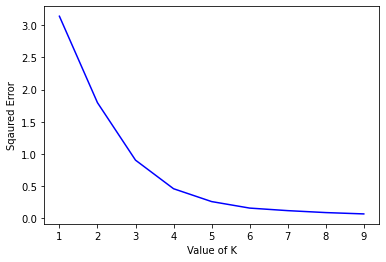

In [77]:
#kmeans clustering and determine to optimum k
from sklearn.cluster import KMeans
import  matplotlib.pyplot as plt

latlong = la_complete[['Venue Latitude', 'Venue Longitude']].values
knumber =[] 
for i in range(1, 10): 
    kmeans = KMeans(n_clusters=i, random_state=0).fit(latlong) 
    knumber.append(kmeans.inertia_)      
  
plt.plot(range(1, 10), knumber, color ='b') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error") 
plt.show()


In [78]:
#run kmeans with optimum number for k
num_clust = 6
clust_longlat = []

latlong = la_complete[['Venue Latitude', 'Venue Longitude']].values
kmeans = KMeans(n_clusters=num_clust, random_state=0).fit(latlong)

cluster_df = pd.DataFrame(kmeans.cluster_centers_, columns=['Cluster Latitude', 'Cluster Longitude'])


In [80]:
#map LA along
la_map = folium.Map(location=[34.052235,  -118.243683], zoom_start=10)

#add markers for coffee shops
for lat, lon in zip(la_complete_coffee['Venue Latitude'], la_complete_coffee['Venue Longitude']):
   folium.CircleMarker([lat, lon], color='red', fill=True, radius=5, parse_html=True).add_to(la_map)

#add markers for offices
for lat, lon in zip(la_complete_office['Venue Latitude'], la_complete_office['Venue Longitude']):
   folium.CircleMarker([lat, lon], color='green', fill=True, radius=5, parse_html=True).add_to(la_map)

for lat, lon in zip(cluster_df['Cluster Latitude'], cluster_df['Cluster Longitude']):
    folium.CircleMarker([lat, lon], color='blue', fill=True, radius=100, parse_html=True).add_to(la_map)

#add neighborhood lines
folium.GeoJson(la_df['geometry']).add_to(la_map)

la_map

In [ ]:
#get the number of offices and coffee shops in each cluster